# CrUX navigation_types metric and Loading Performance

This colab explores the relationship between the [navigation_types metric](https://developer.chrome.com/blog/crux-navigation-types) and the observed loading performance as measured by Largest Contentful Paint, for the top 10k origins in CrUX. As a word of caution up front: corellation does not imply causation; we will be observing corellations here.

In [1]:
#@title Authentication with Google Account and BigQuery Project

from google.colab import auth
from google.cloud import bigquery

#@markdown To connect to BigQuery, it's necessary to authenticate with a Google Account.
#@markdown Running this cell will trigger the authentication flow.
auth.authenticate_user()

#@markdown It's also required to provide a Google Cloud project that is used for BigQuery
#@markdown billing purposes. This is described
#@markdown [in our documentation](https://developer.chrome.com/docs/crux/bigquery#accessing_the_dataset_in_gcp).
#@markdown We do recommend that you use
#@markdown [cost controls](https://cloud.google.com/bigquery/docs/custom-quotas)
#@markdown to avoid unexpected bills.
BIGQUERY_PROJECT = "" # @param {type:"string"}

print('Authenticated')

Authenticated


In [2]:
#@title Fetch the navigation_types fractions for form_factor phone the top 10k origins in CrUX by popularity
#@markdown * We access the `202403` table here (see the `FROM`-clause), and filter
#@markdown   `form_factor` for 'phone' and select origins with [popularity rank](https://developer.chrome.com/blog/crux-rank-magnitude)
#@markdown   <= 10000 for the top 10k most popular origins (see the `WHERE`-clause).
#@markdown * When querying the `navigation_types` metric in BigQuery, it's generally necessary
#@markdown   to divide by the total of the navigation_types fractions, as they will add up
#@markdown   per origin, but not per (origin, form factor) combination
#@markdown   or (origin, form_factor, effective_connection_type) combination.
#@markdown * Not all origins will have `navigation_types`, so it's good practice
#@markdown   to use `SAVE_DIVIDE` (the top 1k origins have `navigation_types`, so
#@markdown   it would not be needed here).
%%bigquery navigation_types_on_phone_for_top10k --project {BIGQUERY_PROJECT}
WITH
  tmp AS (
  SELECT
    origin,
    SUM(navigation_types.navigate.fraction) AS navigate,
    SUM(navigation_types.navigate_cache.fraction) AS navigate_cache,
    SUM(navigation_types.reload.fraction) AS reload,
    SUM(navigation_types.restore.fraction) AS restore,
    SUM(navigation_types.back_forward.fraction) AS back_forward,
    SUM(navigation_types.back_forward_cache.fraction) AS back_forward_cache,
    SUM(navigation_types.prerender.fraction) AS prerender,
    SUM(navigation_types.navigate.fraction + navigation_types.navigate_cache.fraction + navigation_types.reload.fraction + navigation_types.restore.fraction + navigation_types.back_forward.fraction + navigation_types.back_forward_cache.fraction + navigation_types.prerender.fraction) AS total,
  FROM
    `google.com:chrome-ux-report-test.all.202403`
  WHERE
    experimental.popularity.rank <= 10000
    and form_factor.name = 'phone'
  GROUP BY
    origin)
SELECT
  origin,
  ROUND(SAFE_DIVIDE(navigate, total), 4) AS navigate,
  ROUND(SAFE_DIVIDE(navigate_cache, total), 4) AS navigate_cache,
  ROUND(SAFE_DIVIDE(reload, total), 4) AS reload,
  ROUND(SAFE_DIVIDE(restore, total), 4) AS restore,
  ROUND(SAFE_DIVIDE(back_forward, total), 4) AS back_forward,
  ROUND(SAFE_DIVIDE(back_forward_cache, total), 4) AS back_forward_cache,
  ROUND(SAFE_DIVIDE(prerender, total), 4) AS prerender
FROM
  tmp

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
#@title Fetch the fraction of instant and good LCP measurements for form_factor 'phone for the top 10k origins in CrUX by popularity
#@markdown Below, we'll look at how some of the navigation_types fractions correlate with
#@markdown the LCP measurements; so we extract here:
#@markdown * instant_lcp_density - the fraction of page loads on a phone with LCP <= 200ms, for each
#@markdown   origin in the CrUX 10k set. This is quite fast, especially for a phone!
#@markdown * good_lcp_density - the fraction of page loads on a phone with LCP <= 2500ms, for each
#@markdown   origin in the CrUX 10k set. 2500ms is the [documented threshold](https://web.dev/articles/lcp/) for
#@markdown   'good' LCP. Origins and URLs that have at least 75% of their page loads
#@markdown   with LCP below this threshold are said to be 'passing' the [Core Web Vitals](https://web.dev/articles/vitals).
%%bigquery lcp_densities_on_phone_for_top10k  --project {BIGQUERY_PROJECT}
SELECT
  origin,
  SUM(IF(lcp_bin.`end` <= 200, lcp_bin.density, 0)) / SUM(lcp_bin.density) AS instant_lcp_density,
  SUM(IF(lcp_bin.`end` <= 2500, lcp_bin.density, 0)) / SUM(lcp_bin.density) AS good_lcp_density
FROM
  `google.com:chrome-ux-report-test.all.202403`,
  UNNEST(largest_contentful_paint.histogram.bin) AS lcp_bin
WHERE
  experimental.popularity.rank <= 10000
  and form_factor.name = 'phone'
GROUP BY
  origin

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
#@title Join the navigation_types stats and the lcp_densities stats
#@markdown We could have done this in BigQuery / SQL as well - it is a simple join
#@markdown on the origin; we drop rows with n/a values.
top10k_stats = navigation_types_on_phone_for_top10k.set_index('origin').join(
    lcp_densities_on_phone_for_top10k.set_index('origin'), on='origin').dropna()

,back_forward_cache,instant_lcp_density,good_lcp_density
back_forward_cache,1.000000,0.867845,0.28877
instant_lcp_density,0.867845,1.000000,0.35064
good_lcp_density,0.288770,0.350640,1.00000


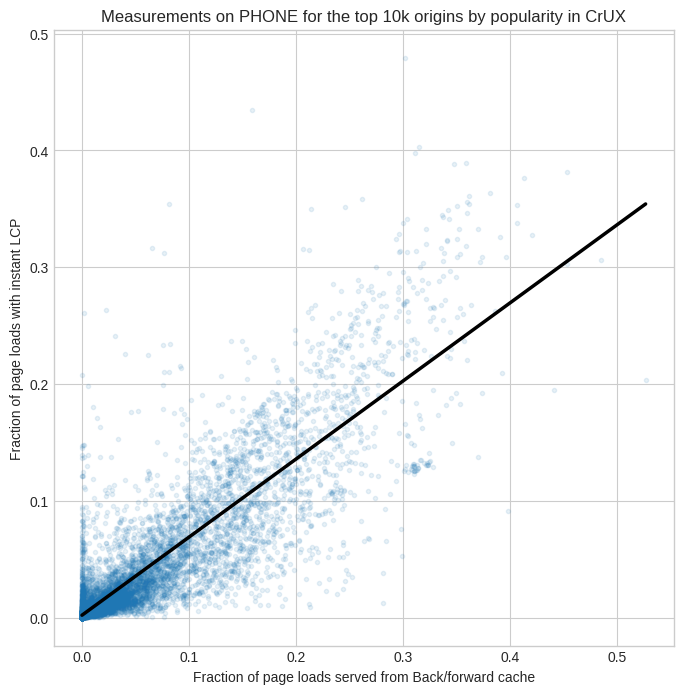

In [7]:
#@title The fraction of pageloads served from the Back/forward cache strongly correlates with instant LCP (<=200ms)
#@markdown * We're looking at the top10k origins in CrUX by popularity.
#@markdown * We're looking at page loads on form factor PHONE.
#@markdown * The x axis shows the fraction of pageloads served from the Back/forward cache (`back_forward_cache`).
#@markdown * The y axis shows the fraction of pageloads with instant LCP (`instant_lcp_density`).
#@markdown * We emit a scatterplot for these data, along with a regression line.
#@markdown * We also show the [Pearson correlation coefficients](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
#@markdown   between `back_forward_cache` ratio,
#@markdown   `instant_lcp_density` (LCP <= 200ms), and `good_lcp_density` (LCP <= 2500ms).
#@markdown * We see a strong positive correlation &rho;=0.867845
#@markdown   between Back/forward cache ratio and instant LCP density. There is also a positive
#@markdown   correlation &rho;=0.28877 between Back/forward cache ratio and good LCP density.

import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('Measurements on PHONE for the top 10k origins by popularity in CrUX')
ax.set_xlabel('Fraction of page loads served from Back/forward cache')
ax.set_ylabel('Fraction of page loads with instant LCP')
ax.plot(top10k_stats['back_forward_cache'], top10k_stats['instant_lcp_density'], '.', alpha=0.1)
b, a = np.polyfit(top10k_stats['back_forward_cache'], top10k_stats['instant_lcp_density'], deg=1)
xseq = np.linspace(0, top10k_stats['back_forward_cache'].max(), num=10)
ax.plot(xseq, a+ b * xseq, color="k", lw=2.5)

top10k_stats[['back_forward_cache', 'instant_lcp_density', 'good_lcp_density']].corr()

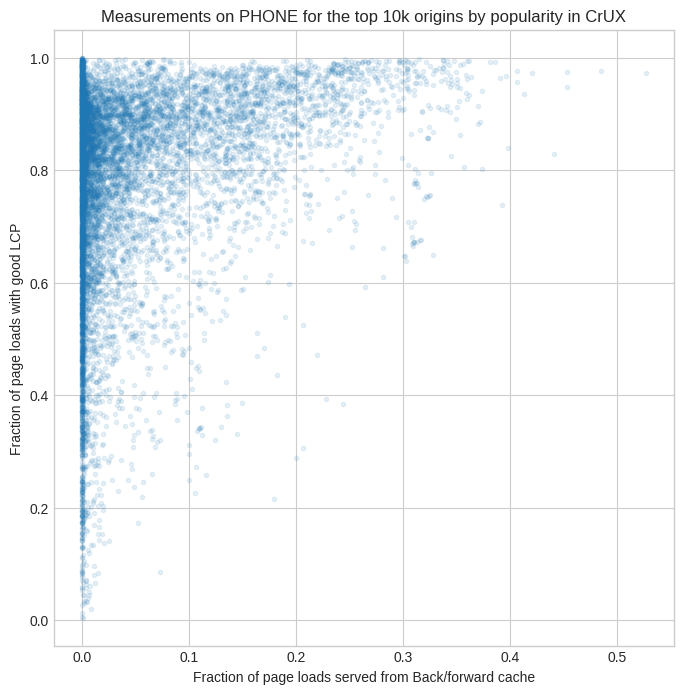

In [8]:
#@title Correlation with good LCP is not quite as strong

#@markdown * We're looking at the top10k origins in CrUX by popularity.
#@markdown * We're looking at page loads on form factor PHONE.
#@markdown * The x axis shows the fraction of pageloads served from the Back/forward cache (`back_forward_cache`).
#@markdown * The y axis shows the fraction of pageloads with good LCP (`good_lcp_density`).
#@markdown * We emit a scatterplot for these data.
#@markdown * Back/forward cache helps with good LCP, but there are also other ways to
#@markdown   achieve a good LCP. This is why this figure looks more noisy than the one
#@markdown   with instant LCP; of course, instant LCP (<=200ms) is actually faster than
#@markdown   good LCP (<=2500ms), so the instant LCP picture is very encouraging
#@markdown   for the importance of Back/forward cache.

import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('Measurements on PHONE for the top 10k origins by popularity in CrUX')
ax.set_xlabel('Fraction of page loads served from Back/forward cache')
ax.set_ylabel('Fraction of page loads with good LCP')
ax.plot(top10k_stats['back_forward_cache'], top10k_stats['good_lcp_density'], '.', alpha=0.1)


,prerender,instant_lcp_density,good_lcp_density
prerender,1.000000,-0.035178,-0.040279
instant_lcp_density,-0.035178,1.000000,0.350640
good_lcp_density,-0.040279,0.350640,1.000000


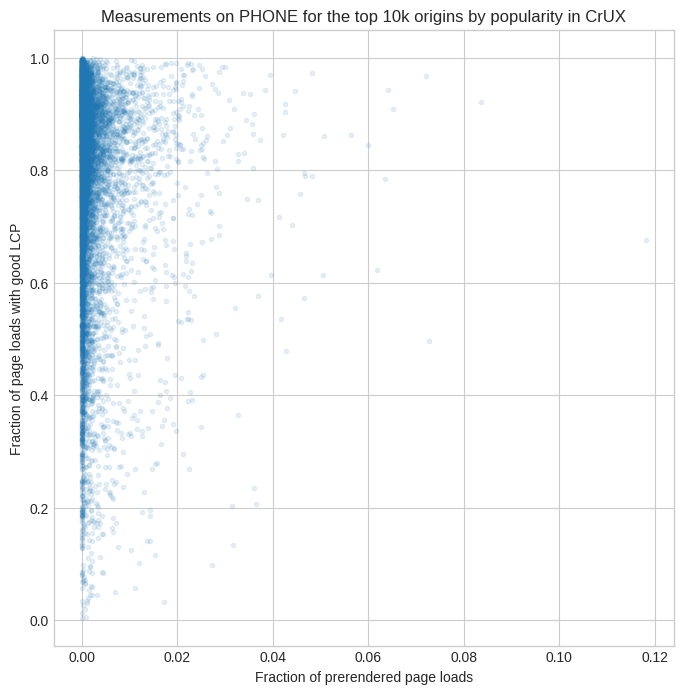

In [9]:
#@title Prerendering is not common enough on PHONE yet to see a strong correlation with loading performance

#@markdown * We're looking at the top10k origins in CrUX by popularity.
#@markdown * We're looking at page loads on form factor PHONE.
#@markdown * The x axis shows the fraction of prerendered pageloads (`prerendered`).
#@markdown * The y axis shows the fraction of pageloads with good LCP (`good_lcp_density`).
#@markdown * We emit a scatterplot for these data.
#@markdown * We also show the [Pearson correlation coefficients](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
#@markdown   between `prerendered` ratio,
#@markdown   `instant_lcp_density` (LCP <= 200ms), and `good_lcp_density` (LCP <= 2500ms).
#@markdown * We're not seeing a strong correlation between these variables; this could be because
#@markdown   for form_factor PHONE, the top10k origins have at most 12% of their pages prerendered thus far.

import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('Measurements on PHONE for the top 10k origins by popularity in CrUX')
ax.set_xlabel('Fraction of prerendered page loads')
ax.set_ylabel('Fraction of page loads with good LCP')
ax.plot(top10k_stats['prerender'], top10k_stats['good_lcp_density'], '.', alpha=0.1)

top10k_stats[['prerender', 'instant_lcp_density', 'good_lcp_density']].corr()

,navigate_cache,instant_lcp_density,good_lcp_density
navigate_cache,1.000000,0.011346,-0.105994
instant_lcp_density,0.011346,1.000000,0.350640
good_lcp_density,-0.105994,0.350640,1.000000


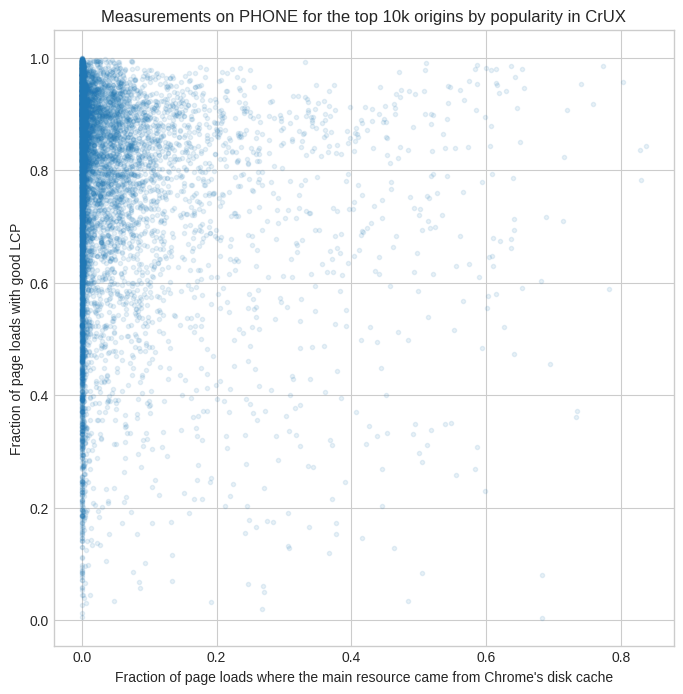

In [10]:
#@title No strong correlation between disk cache and good LCP

#@markdown * We're looking at the top10k origins in CrUX by popularity.
#@markdown * We're looking at page loads on form factor PHONE.
#@markdown * The x axis shows the fraction of pageloads (`navigate_cache`) with their main resource
#@markdown   served from the cache.
#@markdown * The y axis shows the fraction of pageloads with good LCP (`good_lcp_density`).
#@markdown * We emit a scatterplot for these data.
#@markdown * We also show the [Pearson correlation coefficients](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
#@markdown   between `navigate_cache` ratio,
#@markdown   `instant_lcp_density` (LCP <= 200ms), and `good_lcp_density` (LCP <= 2500ms).
#@markdown * We're not seeing a strong correlation between these variables even though the plot may
#@markdown   suggest so to the human eye.

import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('Measurements on PHONE for the top 10k origins by popularity in CrUX')
ax.set_xlabel('Fraction of page loads where the main resource came from Chrome\'s disk cache')
ax.set_ylabel('Fraction of page loads with good LCP')
ax.plot(top10k_stats['navigate_cache'], top10k_stats['good_lcp_density'], '.', alpha=0.1)

top10k_stats[['navigate_cache', 'instant_lcp_density', 'good_lcp_density']].corr()